In [1]:
#!/usr/bin/env python

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

In [2]:
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
name = 'HollandschHuys_full'
system = psl.systems[name]()
system.stats['Y']['mean']

array([22.282671, 21.74605 , 23.210358, 23.336195, 23.287743, 21.885336,
       23.452555, 23.279135, 22.758648, 22.32965 , 22.79069 , 22.571985],
      dtype=float32)

In [33]:
sys.stats['Y']['mean'] - system.stats['Y']['mean']

array([-16.76414  , -19.723694 , -21.262556 , -21.118612 , -19.232677 ,
       -16.247372 , -21.949919 , -22.735956 , -14.3987055, -13.439483 ,
       -18.871891 , -18.4302   ], dtype=float32)

In [32]:
sys.stats['Y']['mean']

array([5.518532 , 2.0223553, 1.9478015, 2.2175822, 4.0550656, 5.6379647,
       1.5026362, 0.5431787, 8.359942 , 8.890168 , 3.9187994, 4.1417847],
      dtype=float32)

In [31]:
system_name = "LinearHollandschHuys_full"
sys = psl.systems[system_name]()
ts = sys.ts
nx = sys.nx
ny = sys.ny
nu = sys.nu
nd = sys.nd
nd_obs = sys.nD_obs
nref = ny

umin = torch.tensor(sys.umin, device=dev)
umax = torch.tensor(sys.umax, device=dev)

In [5]:
normalize = lambda x, mean, std: (x-mean)/std
denormalize = lambda x, mean, std: (x*std)+mean

In [6]:
umean = torch.tensor(sys.stats['U']['mean'], device=dev)
ustd = torch.tensor(sys.stats['U']['std'], device=dev)
xmean = torch.tensor(sys.stats['X']['mean'], device=dev)
xstd = torch.tensor(sys.stats['X']['std'], device=dev)
ymean = torch.tensor(sys.stats['Y']['mean'], device=dev)
ystd = torch.tensor(sys.stats['Y']['std'], device=dev)
dmean = torch.tensor(sys.stats['D']['mean'], device=dev)
dstd = torch.tensor(sys.stats['D']['std'], device=dev)

umin = normalize(umin, umean, ustd)
umax = normalize(umax, umean, ustd)

In [7]:
A = torch.tensor(sys.A, device=dev)
B = torch.tensor(sys.Beta, device=dev)
C = torch.tensor(sys.C, device=dev)
E = torch.tensor(sys.E, device=dev)
F = torch.tensor(sys.F, device=dev)
G = torch.tensor(sys.G, device=dev)
y_ss = torch.tensor(sys.y_ss, device=dev)

In [8]:
def ssm_forward(x, u, d):
    x = denormalize(x, xmean, xstd)
    u = denormalize(u, umean, ustd)
    d = denormalize(d, dmean, dstd)

    x = x @ A.T + u @ B.T + d @ E.T + G.T
    y = x @ C.T + F.T  - y_ss

    x = normalize(x, xmean, xstd)
    y = normalize(y, ymean, ystd)
    return x, y

dist_obs = Node(lambda d: d[:, sys.d_idx], ['d'], ['d_obs'])

In [9]:
def get_policy_data(sys, nsteps, n_samples, xmin_range, batch_size, name="train"):
    #  sampled references for training the policy
    batched_xmin = xmin_range.sample((n_samples, 1, nref)).repeat(1, nsteps + 1, 1).to(dev)
    batched_xmax = batched_xmin + 2.

    # sampled disturbance trajectories from the simulation model
    batched_dist = torch.stack([torch.tensor(sys.get_D(nsteps), device=dev) for _ in range(n_samples)])

    # sampled initial conditions
    batched_x0 = torch.stack([torch.tensor(sys.get_x0(), device=dev).unsqueeze(0) for _ in range(n_samples)])

    data = DictDataset(
        {"x": normalize(batched_x0, xmean, xstd),
         "ymin": normalize(batched_xmin, ymean, ystd),
         "ymax": normalize(batched_xmax, ymean, ystd),
         "d": normalize(batched_dist, dmean, dstd),
         "umin": umin.repeat((n_samples, nsteps, 1)),
         "umax": umax.repeat((n_samples, nsteps, 1)),
         "y": normalize(batched_x0 @ C.T + F.T - y_ss, ymean, ystd)
         
        },
        name=name,
    )
    return DataLoader(data, batch_size=batch_size, collate_fn=data.collate_fn, shuffle=False)

In [10]:
nsteps_test = 1000

# generate reference
np_refs = psl.signals.step(nsteps_test+1, nref, min=18., max=22., randsteps=5)
ymin_val = torch.tensor(np_refs, dtype=torch.float32, device=dev).reshape(1, nsteps_test+1, nref)
ymax_val = ymin_val+2.0
# generate disturbance signal
torch_dist = torch.tensor(sys.get_D(nsteps_test+1), device=dev).unsqueeze(0)
# initial data for closed loop simulation
x0 = torch.tensor(sys.get_x0(), device=dev).reshape(1, 1, nx)
data = {
        "x": normalize(x0, xmean, xstd),
         "ymin": normalize(ymin_val, ymean, ystd),
         "ymax": normalize(ymax_val, ymean, ystd),
         "d": normalize(torch_dist, dmean, dstd),
         "umin": umin.repeat(nsteps_test, 1),
         "umax": umax.repeat(nsteps_test, 1),
         "y": normalize(x0 @ C.T + F.T - y_ss, ymean, ystd)

}

In [11]:
def update_weights(coef, q, epsilon):
    return torch.diag(1 / (coef.flatten()**q + epsilon))

In [12]:
action_weight = 0.1
state_weight = 50.
du_weight = 0.0
u_bound_weight = 1.

def train_func(optim, system, sparsity):
    nsteps = system.nsteps
    # variables
    y = variable('y')
    u = variable('u')
    ymin_val = variable('ymin')
    ymax_val = variable('ymax')
    umin_val = variable('umin')
    umax_val = variable('umax')
    
    l = variable([y], lambda y: torch.norm(list(system.parameters())[0], p))

    loss_l = sparsity*((l == 0))
    
    action_loss = action_weight * ((u == 0.0))  # energy minimization
    du_loss = du_weight * (u[:,:-1,:] - u[:,1:,:] == 0.0)  # delta u minimization to prevent agressive changes in control actions
    
    state_lower_bound_penalty = state_weight*(y > ymin_val)
    state_upper_bound_penalty = state_weight*(y < ymax_val)

    u_lower_bound_penalty = u_bound_weight*(u > umin_val)
    u_upper_bound_penalty = u_bound_weight*(u < umax_val)

    constraints = [state_lower_bound_penalty, state_upper_bound_penalty, u_lower_bound_penalty, u_upper_bound_penalty]
    objectives = [action_loss, loss_l]
    
    components = [system]

    train_loader, dev_loader = [
            get_policy_data(sys, nsteps, n_samples, xmin_range, batch_size, name=name)
            for name in ("train", "dev")]   
    loss = PenaltyLoss(objectives, constraints)
    problem = Problem(components, loss)
    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        optimizer=optim,
        epochs=5000//system.nsteps,
        train_metric='train_loss',
        eval_metric='dev_loss',
        patience=5000//system.nsteps,
        epoch_verbose=1,
        device=dev
    )
    
    # Train control policy
    best_model = trainer.train()
    
    # load best trained model
    trainer.model.load_state_dict(best_model)


    system.nsteps = nsteps
    trainer.badcount = 0



In [13]:
def test(test_data):

    trajectories_sindy = test_data

    sindy_y = denormalize(trajectories_sindy['y'], ymean, ystd)
    sindy_u = denormalize(trajectories_sindy['u'], umean, ustd)

    y_min = denormalize(test_data["ymin"], ymean, ystd)
    y_max = denormalize(test_data["ymax"], ymean, ystd)

    u_min = denormalize(test_data["umin"], umean, ustd)
    u_max = denormalize(test_data["umax"], umean, ustd)
    
    u_loss = action_weight * torch.sum(torch.abs(sindy_u))

    y_lower = torch.sum(torch.abs(torch.max(sindy_y - y_max, torch.zeros(sindy_y.shape, device=dev))))
    y_upper = torch.sum(torch.abs(torch.min(sindy_y - y_min, torch.zeros(sindy_y.shape, device=dev))))

    u_lower = torch.sum(torch.abs(torch.max(sindy_u - u_max, torch.zeros(sindy_u.shape, device=dev))))
    u_upper = torch.sum(torch.abs(torch.min(sindy_u - u_min, torch.zeros(sindy_u.shape, device=dev))))
    

    return (u_loss + state_weight*y_lower +  state_weight*y_upper + 10*u_lower + 10*u_upper).item()

In [15]:
torch.manual_seed(0)

n_samples = 3000    # number of sampled scenarios
batch_size = 1500
xmin_range = torch.distributions.Uniform(18., 22.)

max_degree = 1
max_freq = 3
sparsity = 0
p = 1
#theta_1 = library.FourierLibrary(ny, 2*nref+nd_obs, max_freq=max_freq, include_cos=False)
theta_2 = library.PolynomialLibrary(ny, 2*nref+nd_obs, max_degree=max_degree, interaction=False)
names = ['1', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5',
        'y0_min', 'y1_min', 'y2_min', 'y3_min', 'y4_min', 'y5_min',
        'y0_max', 'y1_max', 'y2_max', 'y3_max', 'y4_max', 'y5_max',
         'd']
theta_2.function_names = names

In [16]:
torch.cuda.empty_cache()

In [29]:
nsteps = 100
poly_sindy = sindy.SINDy(theta_2, n_out=nu)  
#u_bound_node = Node(lambda u: torch.clamp(u, umin, umax), ['u_un'], ['u'])
policy_node = Node(poly_sindy,  ['y', 'R'], ['u']).to(dev)
combined_y = Node(lambda ymin, ymax, d: torch.cat([ymin, ymax, d], dim=-1),
              ['ymin', 'ymax', 'd_obs'], ['R'], name="y")
ssm = Node(ssm_forward, ['x', 'u', 'd'], ['x', 'y'])
poly_system = System([dist_obs, combined_y, policy_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(poly_sindy.parameters(), lr=.06)

In [ ]:
train_func(optimizer, poly_system, sparsity)

In [21]:
nsteps = 100

four_sindy = sindy.SINDy(theta_1, n_out=nu)  
policy_node = Node(four_sindy,  ['y', 'R'], ['u_un']).to(dev)

four_system = System([dist_obs, combined_y, policy_node,ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(four_sindy.parameters(), lr=.06)

In [22]:
train_func(optimizer, four_system, sparsity)

KeyError: 'u'

In [24]:
poly_system.nsteps = nsteps_test
#four_system.nsteps = nsteps_test

In [25]:
trajectories_poly = poly_system(data)
#trajectories_four = four_system(data)

In [26]:
poly_y = denormalize(trajectories_poly['y'], ymean, ystd)
poly_u = denormalize(trajectories_poly['u'], umean, ustd)
#four_y = denormalize(trajectories_four['y'], ymean, ystd)
#four_u = denormalize(trajectories_four['u'], umean, ustd)

y_min = denormalize(data["ymin"], ymean, ystd)
y_max = denormalize(data["ymax"], ymean, ystd)

u_min = denormalize(data["umin"], umean, ustd)
u_max = denormalize(data["umax"], umean, ustd)
#loss_poly = test(trajectories_poly)
#loss_four = test(trajectories_four)

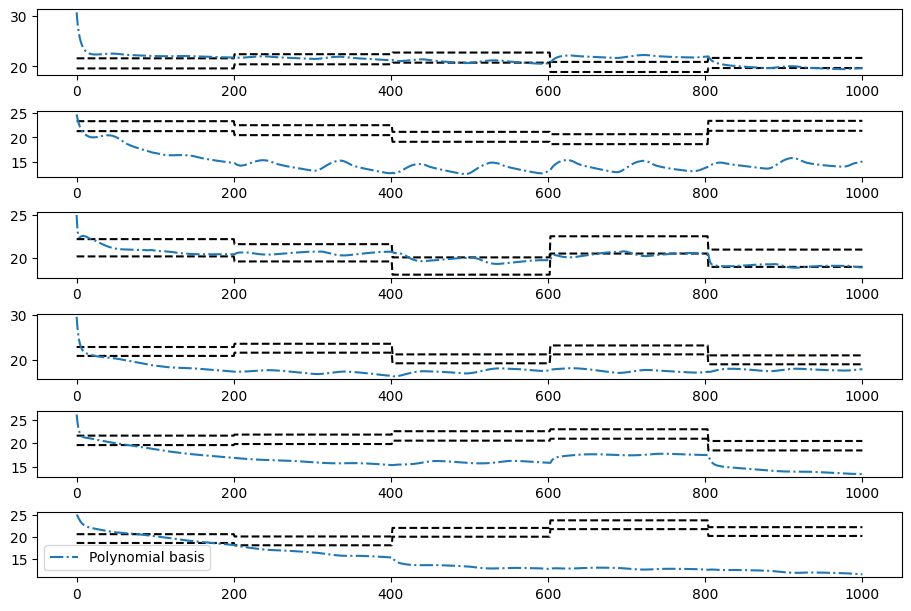

In [28]:
fig, ax = plt.subplots(nrows=ny, constrained_layout=True, figsize=(9,6))
for i in range(ny):
    ax[i].plot(y_min.cpu().numpy().reshape(-1, ny)[:,i], "--", color="black")
    ax[i].plot(y_max.cpu().numpy().reshape(-1, ny)[:,i], "--", color="black")
    ax[i].plot(poly_y.cpu().detach().numpy().reshape(nsteps_test+1, ny)[:,i], '-.', label='Polynomial basis')
    #ax[i].plot(four_y.cpu().detach().numpy().reshape(nsteps_test+1, ny)[:,i], '--', label='Fourier basis')

"""fig.text(0, -0.1, 
           f"Penalty using Polynomial Basis: {loss_poly:.4f}\n"
           f"Penalty using Fourier Basis: {loss_four:.4f}")
"""
plt.legend()

plt.savefig("fourier_polynomial_hard_y.png")

In [ ]:
fig, ax = plt.subplots(nrows=nu, constrained_layout=True, figsize=(9,6))
for i in range(nu):
    ax[i].plot(u_min.cpu().numpy().reshape(-1, nu)[:,i], "--", color="black")
    ax[i].plot(u_max.cpu().numpy().reshape(-1, nu)[:,i], "--", color="black")
    ax[i].plot(poly_u.cpu().detach().numpy().reshape(nsteps_test, nu)[:,i], '-.',label='Polynomial basis')
    #ax[i].plot(four_u.cpu().detach().numpy().reshape(nsteps_test, nu)[:,i], '--',label='Fourier basis')

plt.savefig("fourier_polynomial_hard_u.png")